# Assignment 2: Anime Recommendation Analysis

## Dataset: Anime Recommendations Database

This notebook contains the analysis for anime rating prediction and classification using machine learning.


---

# Section 1: Identify the Predictive Task

## Task 1: Regression - Predicting Anime Rating

Predict the rating of an anime (continuous value from 1-10).

- Input: Anime features (genre, type, episodes, members)
- Output: Rating (continuous value, typically 1-10)
- Problem Type: Supervised regression
- Dataset: User ratings from `rating.csv` aggregated per anime, merged with `anime.csv` features

## Task 2: Binary Classification - Predicting Anime Type (TV vs Movie)

Predict whether an anime is a TV series or Movie (binary classification).

- Input: Same anime features as Task 1
- Output: Binary label (TV = 0, Movie = 1, or other binary split)
- Problem Type: Supervised binary classification
- Dataset: Samples with valid type labels


## How We Will Evaluate Our Models

### Task 1 (Regression - Rating Prediction):

- **RMSE (Root Mean Squared Error):** Primary metric for regression
- **R² Score:** Proportion of variance explained (0 = baseline, 1 = perfect)
- **MAE (Mean Absolute Error):** Average prediction error

**Evaluation Protocol:**
- 80/20 train/test split
- 5-fold cross-validation for model selection
- Report RMSE, R², and MAE on test set

### Task 2 (Binary Classification - Type Prediction):

- **Accuracy:** Overall correctness
- **Precision:** Of predicted positives, how many are correct
- **Recall:** Of actual positives, how many were caught
- **F1-Score:** Balances precision and recall
- **ROC-AUC:** Model discrimination across thresholds (0.5 = random, 1.0 = perfect)

**Evaluation Protocol:**
- 80/20 stratified train/test split
- 5-fold stratified cross-validation for model selection
- Report all metrics (Accuracy, Precision, Recall, F1, ROC-AUC)


## Relevant Baselines for Comparison

### Task 1 (Regression - Rating Prediction):

**Baseline 1: Mean Rating Predictor**
- Always predicts the mean rating
- Expected: R² = 0, baseline RMSE

**Baseline 2: Linear Regression (No Regularization)** - **MAIN BASELINE**
- Linear Regression without regularization
- Features: All features (genre, type, episodes, members, etc.)
- Purpose: Baseline ML performance before adding regularization

**Comparison:** Our models (Linear Regression with L1/L2 regularization - Lasso/Ridge) should outperform this baseline, demonstrating regularization benefits.

### Task 2 (Binary Classification - Type Prediction):

**Baseline 1: Random Classifier**
- Randomly predicts TV or Movie (50/50)
- Expected: ~50% accuracy, ROC-AUC ~0.50

**Baseline 2: Majority Class Classifier**
- Always predicts most common type
- Expected: Accuracy = proportion of majority class

**Baseline 3: Logistic Regression (No Regularization)** - **MAIN BASELINE**
- Logistic Regression without regularization (C=1.0)
- Features: All features (genre, type, episodes, members, etc.)
- Purpose: Baseline ML performance before adding regularization

**Comparison:** Our models (Logistic Regression with L1/L2 regularization) should outperform this baseline.


## How We Will Assess Prediction Validity

We use validation strategies to ensure predictions are reliable and generalizable:

1. **Train/Test Split with Stratification**
   - **Task 1:** 80/20 split (standard split for regression)
   - **Task 2:** 80/20 split, stratified by type (maintains class distribution)
   - Purpose: Evaluate on unseen data, prevent overfitting

2. **Cross-Validation for Model Selection**
   - 5-fold cross-validation on training set
   - Purpose: Select best hyperparameters (alpha values for Lasso/Ridge, C values for Logistic Regression)
   - Use: Compare models, regularization strengths, feature combinations

3. **Residual Analysis** (Task 1 only)
   - Plot residuals vs predicted values
   - Check for patterns indicating model misspecification

4. **Confusion Matrix Analysis** (Task 2 only)
   - Analyze TP, TN, FP, FN
   - Identify if model is too conservative or aggressive

5. **Learning Curves**
   - Plot training vs validation performance
   - Detect overfitting (large gap) or underfitting (both low)

6. **Feature Importance Analysis**
   - Analyze coefficients (linear/logistic regression) or feature importances (tree-based models)
   - Validate features align with domain knowledge

7. **ROC Curve Analysis** (Task 2 only)
   - Plot TPR vs FPR across all thresholds
   - Compare models and select optimal threshold

8. **Performance Stability**
   - Evaluate on multiple random splits
   - Ensure consistent performance

These strategies ensure our models' predictions are reliable, generalizable, and not overfitted.


In [1]:
# Load and clean the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load anime metadata
df_anime = pd.read_csv('anime.csv')

# Load user ratings for Task 1
print("Loading rating.csv...")
df_ratings = pd.read_csv('rating.csv')
print(f"Total rating records: {len(df_ratings):,}")

# Filter for valid ratings (1-10, exclude -1)
df_ratings_valid = df_ratings[df_ratings['rating'] >= 1].copy()
print(f"Valid ratings (1-10): {len(df_ratings_valid):,}")
print(f"Invalid ratings (-1): {(df_ratings['rating'] == -1).sum():,}")

# Aggregate ratings per anime (mean rating)
print("\nAggregating ratings per anime...")
df_ratings_agg = df_ratings_valid.groupby('anime_id')['rating'].agg(['mean', 'count']).reset_index()
df_ratings_agg.columns = ['anime_id', 'rating_mean', 'rating_count']
print(f"Unique anime with ratings: {len(df_ratings_agg):,}")

# Merge ratings with anime metadata for Task 1
df_task1_merged = df_anime.merge(df_ratings_agg, on='anime_id', how='inner')
print(f"\nTask 1 dataset (merged): {len(df_task1_merged):,} samples")

# For Task 2, use original anime.csv (keep type information)
df_clean = df_anime.copy()

# Check for duplicate rows
print(f"\nNumber of duplicate rows in anime.csv: {df_clean.duplicated().sum()}")

# Remove rows with missing type (target for Task 2)
print(f"Rows with missing type: {df_clean['type'].isnull().sum()}")
df_clean = df_clean[df_clean['type'].notna()].copy()

print(f"\nTask 2 dataset shape: {df_clean.shape}")
print(f"Task 1 rating range: {df_task1_merged['rating_mean'].min():.2f} - {df_task1_merged['rating_mean'].max():.2f}")


Loading rating.csv...
Total rating records: 7,813,737
Valid ratings (1-10): 6,337,241
Invalid ratings (-1): 1,476,496

Aggregating ratings per anime...
Unique anime with ratings: 9,927

Task 1 dataset (merged): 9,926 samples

Number of duplicate rows in anime.csv: 0
Rows with missing type: 25

Task 2 dataset shape: (12269, 7)
Task 1 rating range: 1.00 - 10.00



# Section 2: Exploratory Analysis, Data Collection, Pre-processing, and Discussion

## 2.1 Context: Dataset Source and Collection

### Dataset Source:
- **Dataset:** Anime Recommendations Database
- **Source:** Kaggle (https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)
- **Creator:** Cooper Union

### What is it for:
This dataset contains information about anime series and movies, including ratings, genres, types, and member counts. It was collected for recommendation systems and analysis of anime preferences.

### How was it collected:
The dataset appears to be scraped or collected from anime databases/websites (likely MyAnimeList or similar platforms) where users rate and review anime. The data includes:
- **Task 1:** User ratings from `rating.csv` (individual user ratings per anime, aggregated to mean rating per anime)
- **Task 2:** Metadata about each anime (genre, type, episodes) from `anime.csv`
- Popularity metrics (member counts)

### Dataset Characteristics:
- **Task 1:** User ratings from `rating.csv` (~7.8M records) aggregated per anime, merged with `anime.csv` metadata
- **Task 2:** `anime.csv` with 12,294 anime entries
- **Features:** anime_id, name, genre, type, episodes, members (from anime.csv), plus rating_mean and rating_count (from rating.csv for Task 1)
- **Time period:** Historical anime data (exact collection date not specified)
- **Coverage:** Various anime types (TV, Movie, OVA, Special, ONA, Music)


## 2.2 Discussion: Data Processing

### Initial Data Quality Assessment:

**Task 1 (Rating Prediction):**
1. **Rating Data (`rating.csv`):**
   - ~7.8M user rating records
   - Valid ratings (1-10): ~6.3M records
   - Invalid ratings (-1): ~1.5M records (excluded)
   - Aggregated to mean rating per anime
   - Merged with `anime.csv` to get features

2. **Missing Values:**
   - Genre: Some missing - can be handled via imputation or indicator variables
   - Episodes: Stored as object type (needs conversion)

**Task 2 (Type Classification):**
1. **Missing Values:**
   - Type: 25 missing (0.20%) - removed for Task 2
   - Genre: 62 missing (0.50%) - can be handled via imputation or indicator variables
   - Episodes: All present but stored as object type (needs conversion)

2. **Data Type Issues:**
   - Episodes column stored as object (string) instead of numeric
   - Some episodes contain "Unknown" values
   - Need to convert to numeric or handle special values

3. **Data Cleaning Steps:**
   - **Task 1:** Filtered valid ratings (1-10), aggregated per anime, merged with anime metadata
   - **Task 2:** Removed rows with missing type (required for Task 2)
   - Final Task 2 dataset: 12,064 samples
   - No duplicate rows found

### Feature Engineering Considerations:

1. **Genre Feature:**
   - Currently stored as comma-separated strings (e.g., "Action, Adventure, Drama")
   - Need to: split into individual genres, create binary indicators, or use text processing

2. **Episodes Feature:**
   - Contains numeric values and "Unknown" strings
   - Need to: convert to numeric, handle "Unknown" as missing or separate category

3. **Type Feature:**
   - 6 categories: TV, OVA, Movie, Special, ONA, Music
   - For Task 2: Focus on TV vs Movie for binary classification
   - Can use one-hot encoding for multiclass or binary encoding for binary task

4. **Members Feature:**
   - Represents popularity (number of users who added anime to their list)
   - May need log transformation if highly skewed
   - Good predictor for rating (popular anime may have higher ratings)

### Processing Pipeline:
1. Load raw data
2. Remove missing target variables (rating, type)
3. Convert episodes to numeric (handle "Unknown")
4. Process genre (split, encode)
5. Encode categorical features (type)
6. Scale/normalize features as needed


## 2.3 Code: Exploratory Data Analysis

### 2.3.1 Dataset Overview and Statistics


In [2]:
# Detailed dataset statistics
print("="*70)
print("TASK 1 DATASET OVERVIEW (Rating Prediction)")
print("="*70)
print(f"\nTotal samples: {len(df_task1_merged):,}")
print(f"Features: {len(df_task1_merged.columns)}")
print(f"Memory usage: {df_task1_merged.memory_usage(deep=True).sum() / 1024:.2f} KB")

print("\n" + "="*70)
print("TASK 1 NUMERICAL FEATURES SUMMARY")
print("="*70)
if 'episodes' in df_task1_merged.columns:
    print(df_task1_merged[['rating_mean', 'members', 'episodes']].describe())
else:
    print(df_task1_merged[['rating_mean', 'members']].describe())

print("\n" + "="*70)
print("TASK 2 DATASET OVERVIEW (Type Classification)")
print("="*70)
print(f"\nTotal samples: {len(df_clean):,}")
print(f"Features: {len(df_clean.columns)}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024:.2f} KB")

print("\n" + "="*70)
print("TASK 2 MISSING VALUES AFTER CLEANING")
print("="*70)
print(df_clean.isnull().sum())
print(f"\nMissing percentage:")
print((df_clean.isnull().sum() / len(df_clean) * 100).round(2))


TASK 1 DATASET OVERVIEW (Rating Prediction)

Total samples: 9,926
Features: 9
Memory usage: 3161.42 KB

TASK 1 NUMERICAL FEATURES SUMMARY
       rating_mean       members
count  9926.000000  9.926000e+03
mean      6.637702  2.183188e+04
std       1.298712  5.978675e+04
min       1.000000  3.300000e+01
25%       6.066667  5.840000e+02
50%       6.897932  2.524500e+03
75%       7.491369  1.389550e+04
max      10.000000  1.013917e+06

TASK 2 DATASET OVERVIEW (Type Classification)

Total samples: 12,269
Features: 7
Memory usage: 3793.68 KB

TASK 2 MISSING VALUES AFTER CLEANING
anime_id      0
name          0
genre        59
type          0
episodes      0
rating      205
members       0
dtype: int64

Missing percentage:
anime_id    0.00
name        0.00
genre       0.48
type        0.00
episodes    0.00
rating      1.67
members     0.00
dtype: float64


In [4]:
# Convert episodes to numeric (handle "Unknown") - for both Task 1 and Task 2
df_task1_merged['episodes'] = pd.to_numeric(df_task1_merged['episodes'], errors='coerce')
df_clean['episodes'] = pd.to_numeric(df_clean['episodes'], errors='coerce')

print("="*70)
print("EPISODES FEATURE ANALYSIS (Task 1)")
print("="*70)
print(f"Episodes with 'Unknown': {df_task1_merged['episodes'].isnull().sum()}")
print(f"\nEpisodes statistics:")
print(df_task1_merged['episodes'].describe())
print(f"\nEpisodes distribution (top values):")
print(df_task1_merged['episodes'].value_counts().head(10))

print("\n" + "="*70)
print("EPISODES FEATURE ANALYSIS (Task 2)")
print("="*70)
print(f"Episodes with 'Unknown': {df_clean['episodes'].isnull().sum()}")
print(f"\nEpisodes statistics:")
print(df_clean['episodes'].describe())


EPISODES FEATURE ANALYSIS (Task 1)
Episodes with 'Unknown': 3

Episodes statistics:
count    9923.000000
mean       12.542679
std        48.466072
min         1.000000
25%         1.000000
50%         2.000000
75%        12.000000
max      1818.000000
Name: episodes, dtype: float64

Episodes distribution (top values):
episodes
1.0     4454
2.0      991
12.0     732
13.0     526
3.0      450
26.0     407
4.0      296
6.0      238
24.0     164
25.0     147
Name: count, dtype: int64

EPISODES FEATURE ANALYSIS (Task 2)
Episodes with 'Unknown': 315

Episodes statistics:
count    11954.000000
mean        12.382550
std         46.865352
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64


### 2.3.2 Target Variable Analysis


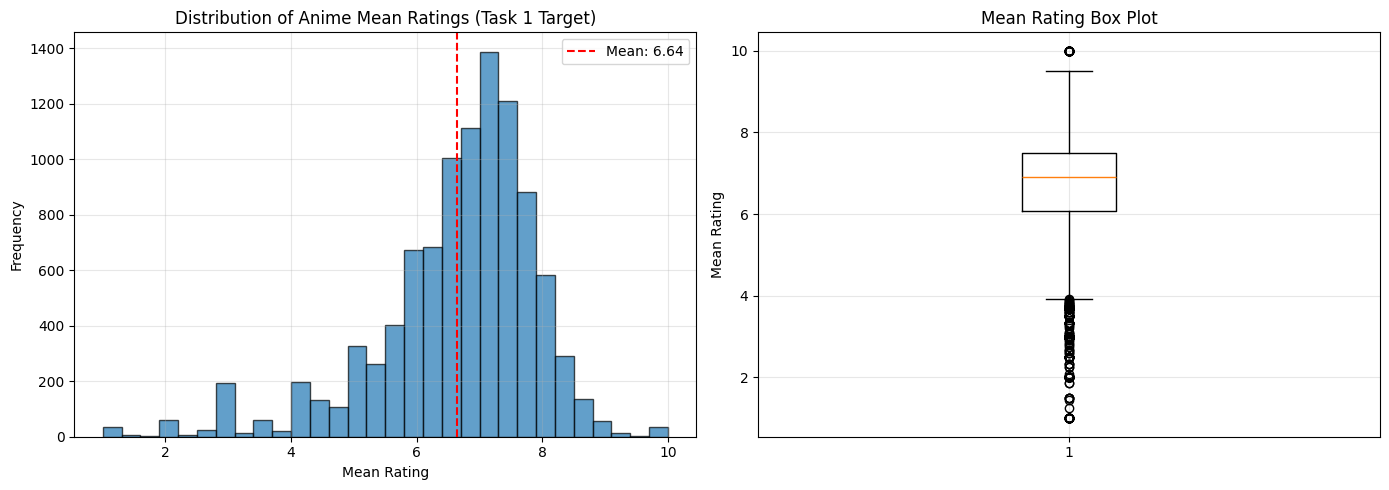

RATING STATISTICS (Task 1 Target - from rating.csv)
Mean: 6.64
Median: 6.90
Std Dev: 1.30
Min: 1.00
Max: 10.00
Skewness: -1.27

Number of user ratings per anime:
Mean: 638.45
Median: 57.00
Min: 1
Max: 34226


In [5]:
# Task 1 Target: Rating Distribution (from rating.csv aggregated)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating histogram
axes[0].hist(df_task1_merged['rating_mean'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Mean Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Anime Mean Ratings (Task 1 Target)')
axes[0].axvline(df_task1_merged['rating_mean'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_task1_merged["rating_mean"].mean():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rating box plot
axes[1].boxplot(df_task1_merged['rating_mean'], vert=True)
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Mean Rating Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("RATING STATISTICS (Task 1 Target - from rating.csv)")
print("="*70)
print(f"Mean: {df_task1_merged['rating_mean'].mean():.2f}")
print(f"Median: {df_task1_merged['rating_mean'].median():.2f}")
print(f"Std Dev: {df_task1_merged['rating_mean'].std():.2f}")
print(f"Min: {df_task1_merged['rating_mean'].min():.2f}")
print(f"Max: {df_task1_merged['rating_mean'].max():.2f}")
print(f"Skewness: {df_task1_merged['rating_mean'].skew():.2f}")
print(f"\nNumber of user ratings per anime:")
print(f"Mean: {df_task1_merged['rating_count'].mean():.2f}")
print(f"Median: {df_task1_merged['rating_count'].median():.2f}")
print(f"Min: {df_task1_merged['rating_count'].min()}")
print(f"Max: {df_task1_merged['rating_count'].max()}")


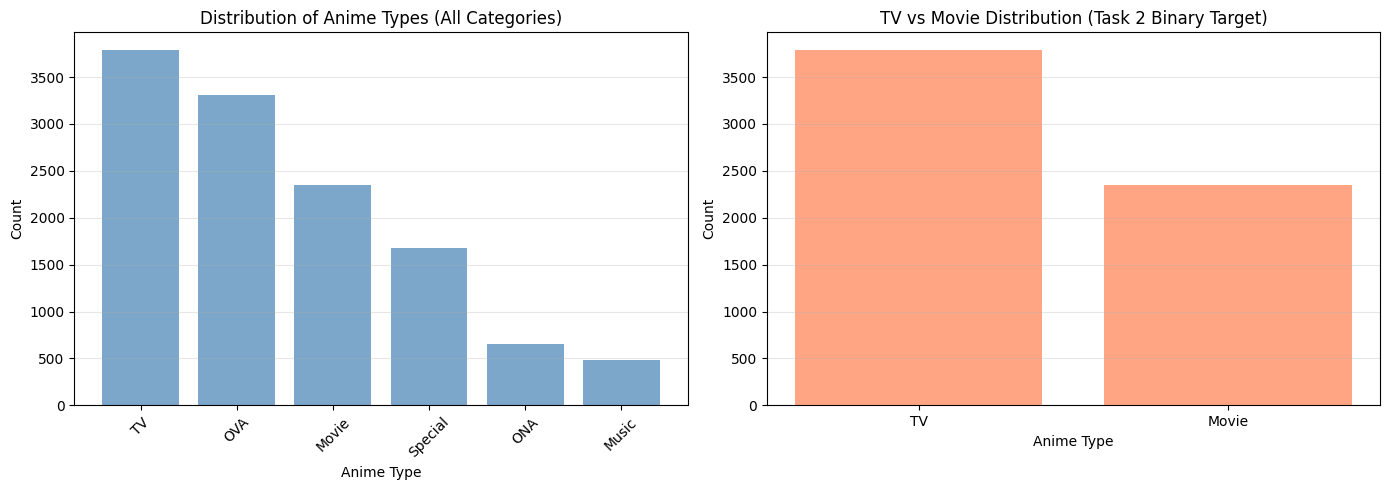

TYPE DISTRIBUTION (Task 2 Target)

All types:
type
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: count, dtype: int64

Total: 12269

TV vs Movie (for binary classification):
type
TV       3787
Movie    2348
Name: count, dtype: int64
TV percentage: 61.73%
Movie percentage: 38.27%


In [6]:
# Task 2 Target: Type Distribution
df_task2 = df_clean[df_clean['type'].notna()].copy()
df_task2_binary = df_task2[df_task2['type'].isin(['TV', 'Movie'])].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All types distribution
type_counts = df_clean['type'].value_counts()
axes[0].bar(type_counts.index, type_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Anime Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Anime Types (All Categories)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# TV vs Movie (for binary classification)
tv_movie_counts = df_task2_binary['type'].value_counts()
axes[1].bar(tv_movie_counts.index, tv_movie_counts.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Anime Type')
axes[1].set_ylabel('Count')
axes[1].set_title('TV vs Movie Distribution (Task 2 Binary Target)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("="*70)
print("TYPE DISTRIBUTION (Task 2 Target)")
print("="*70)
print("\nAll types:")
print(df_clean['type'].value_counts())
print(f"\nTotal: {len(df_clean)}")
print("\nTV vs Movie (for binary classification):")
print(df_task2_binary['type'].value_counts())
print(f"TV percentage: {(df_task2_binary['type'] == 'TV').sum() / len(df_task2_binary) * 100:.2f}%")
print(f"Movie percentage: {(df_task2_binary['type'] == 'Movie').sum() / len(df_task2_binary) * 100:.2f}%")


### 2.3.3 Feature Analysis


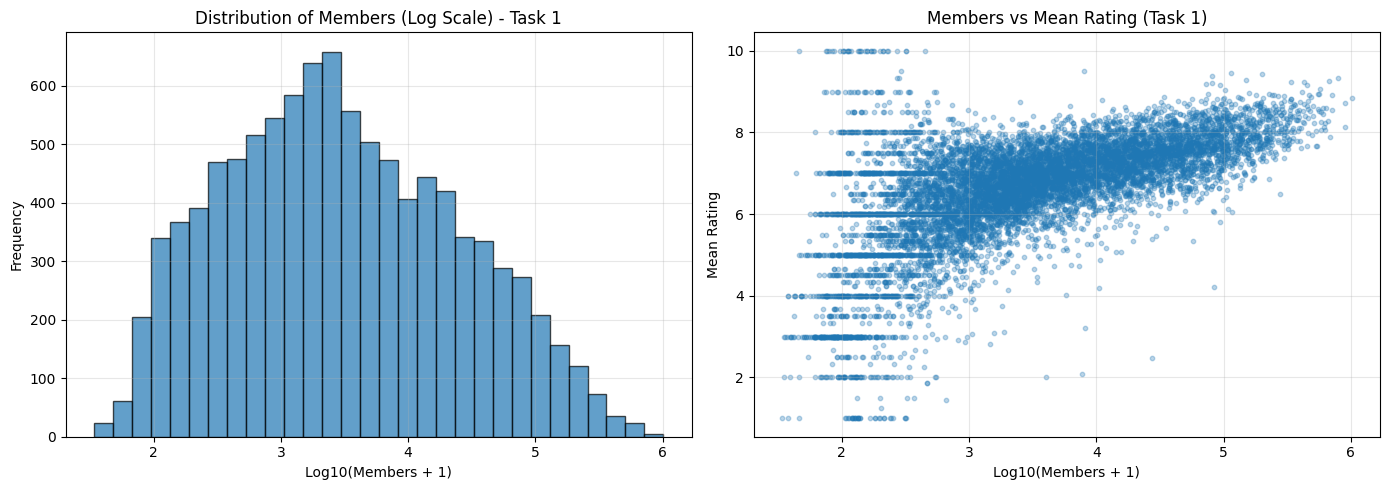

MEMBERS (POPULARITY) STATISTICS - TASK 1
count    9.926000e+03
mean     2.183188e+04
std      5.978675e+04
min      3.300000e+01
25%      5.840000e+02
50%      2.524500e+03
75%      1.389550e+04
max      1.013917e+06
Name: members, dtype: float64

Correlation with rating_mean: 0.3307


In [7]:
# Members (popularity) analysis - Task 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Members distribution (log scale)
axes[0].hist(np.log10(df_task1_merged['members'] + 1), bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log10(Members + 1)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Members (Log Scale) - Task 1')
axes[0].grid(True, alpha=0.3)

# Members vs Rating scatter
axes[1].scatter(np.log10(df_task1_merged['members'] + 1), df_task1_merged['rating_mean'], 
                alpha=0.3, s=10)
axes[1].set_xlabel('Log10(Members + 1)')
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Members vs Mean Rating (Task 1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("MEMBERS (POPULARITY) STATISTICS - TASK 1")
print("="*70)
print(df_task1_merged['members'].describe())
print(f"\nCorrelation with rating_mean: {df_task1_merged[['members', 'rating_mean']].corr().iloc[0,1]:.4f}")


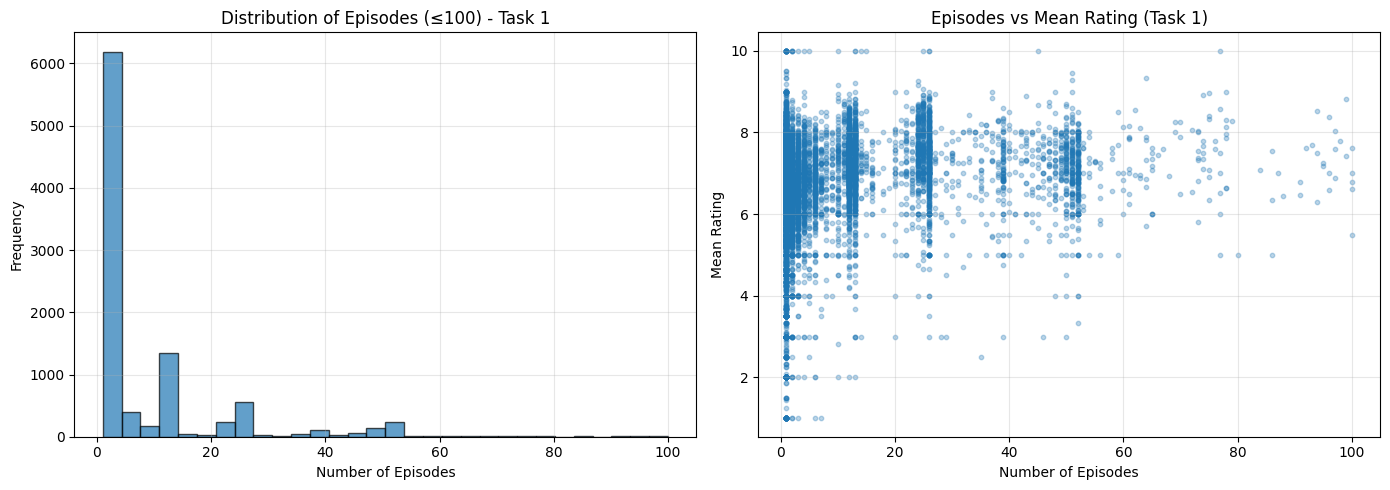

EPISODES STATISTICS - TASK 1
count    9923.000000
mean       12.542679
std        48.466072
min         1.000000
25%         1.000000
50%         2.000000
75%        12.000000
max      1818.000000
Name: episodes, dtype: float64

Correlation with rating_mean: 0.0806


In [8]:
# Episodes analysis - Task 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Episodes distribution (excluding Unknown)
episodes_clean_task1 = df_task1_merged['episodes'].dropna()
axes[0].hist(episodes_clean_task1[episodes_clean_task1 <= 100], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Episodes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Episodes (≤100) - Task 1')
axes[0].grid(True, alpha=0.3)

# Episodes vs Rating
axes[1].scatter(episodes_clean_task1[episodes_clean_task1 <= 100], 
                df_task1_merged.loc[episodes_clean_task1[episodes_clean_task1 <= 100].index, 'rating_mean'],
                alpha=0.3, s=10)
axes[1].set_xlabel('Number of Episodes')
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Episodes vs Mean Rating (Task 1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("EPISODES STATISTICS - TASK 1")
print("="*70)
print(episodes_clean_task1.describe())
print(f"\nCorrelation with rating_mean: {df_task1_merged[['episodes', 'rating_mean']].corr().iloc[0,1]:.4f}")


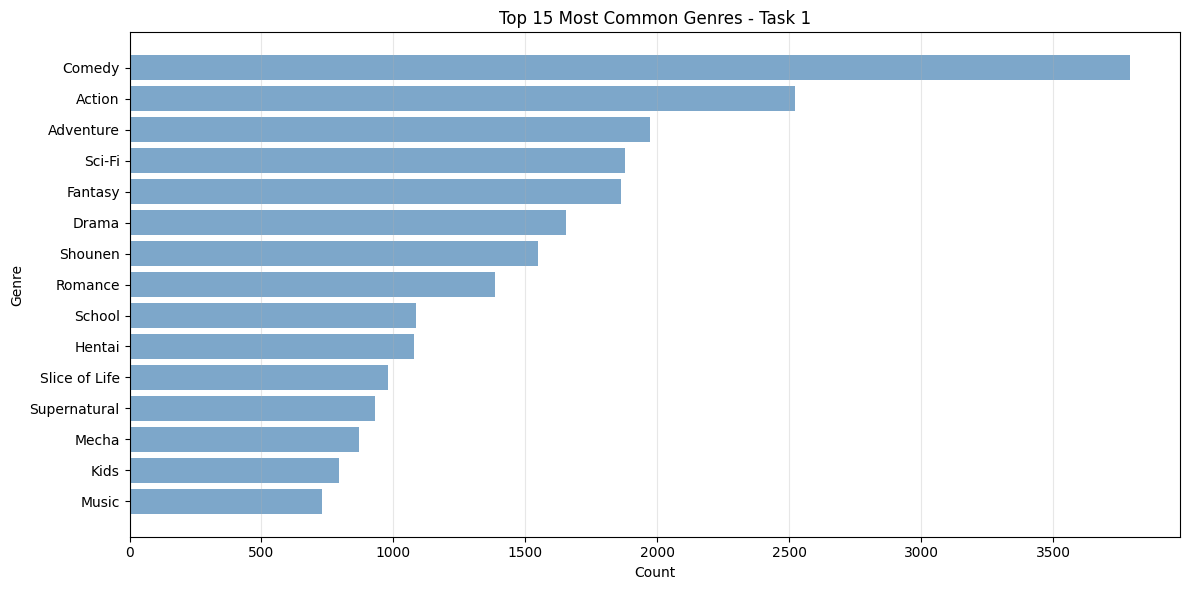

TOP 15 GENRES - TASK 1
Comedy                        :  3792 (38.20%)
Action                        :  2524 (25.43%)
Adventure                     :  1972 (19.87%)
Sci-Fi                        :  1878 (18.92%)
Fantasy                       :  1864 (18.78%)
Drama                         :  1655 (16.67%)
Shounen                       :  1547 (15.59%)
Romance                       :  1385 (13.95%)
School                        :  1084 (10.92%)
Hentai                        :  1080 (10.88%)
Slice of Life                 :   980 (9.87%)
Supernatural                  :   931 (9.38%)
Mecha                         :   869 (8.75%)
Kids                          :   795 (8.01%)
Music                         :   728 (7.33%)


In [9]:
# Genre analysis - Top genres (Task 1)
from collections import Counter

# Split genres and count
genres_list_task1 = df_task1_merged['genre'].dropna().str.split(', ').tolist()
all_genres_task1 = [genre for sublist in genres_list_task1 for genre in sublist]
genre_counts_task1 = Counter(all_genres_task1)
top_genres_task1 = dict(genre_counts_task1.most_common(15))

# Plot top genres
plt.figure(figsize=(12, 6))
plt.barh(list(top_genres_task1.keys()), list(top_genres_task1.values()), color='steelblue', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 15 Most Common Genres - Task 1')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("="*70)
print("TOP 15 GENRES - TASK 1")
print("="*70)
for genre, count in list(genre_counts_task1.most_common(15)):
    print(f"{genre:30s}: {count:5d} ({count/len(df_task1_merged)*100:.2f}%)")


### 2.3.4 Relationship Analysis


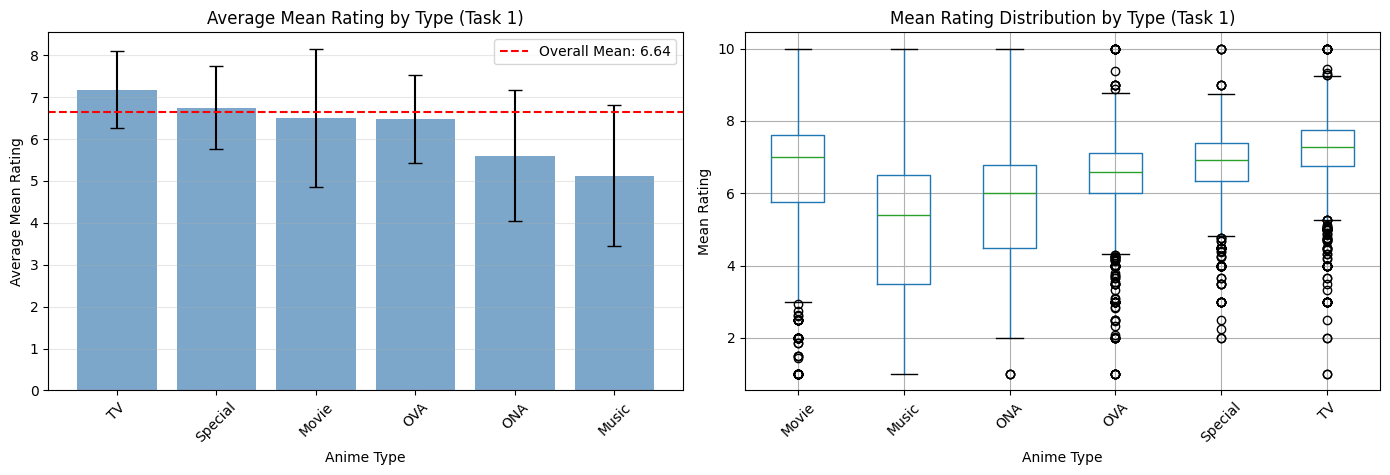

RATING BY TYPE - TASK 1
             mean       std  count
type                              
TV       7.178033  0.923299   3069
Special  6.753091  0.996030   1448
Movie    6.498886  1.644112   1755
OVA      6.484968  1.045936   2730
ONA      5.601756  1.564319    478
Music    5.128821  1.679710    445


In [10]:
# Rating by Type - Task 1
type_rating_task1 = df_task1_merged.groupby('type')['rating_mean'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average rating by type
axes[0].bar(type_rating_task1.index, type_rating_task1['mean'], yerr=type_rating_task1['std'], 
            color='steelblue', alpha=0.7, capsize=5)
axes[0].set_xlabel('Anime Type')
axes[0].set_ylabel('Average Mean Rating')
axes[0].set_title('Average Mean Rating by Type (Task 1)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(df_task1_merged['rating_mean'].mean(), color='red', linestyle='--', 
                label=f'Overall Mean: {df_task1_merged["rating_mean"].mean():.2f}')
axes[0].legend()

# Box plot: Rating by Type
df_task1_merged.boxplot(column='rating_mean', by='type', ax=axes[1], grid=True)
axes[1].set_xlabel('Anime Type')
axes[1].set_ylabel('Mean Rating')
axes[1].set_title('Mean Rating Distribution by Type (Task 1)')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()

print("="*70)
print("RATING BY TYPE - TASK 1")
print("="*70)
print(type_rating_task1)


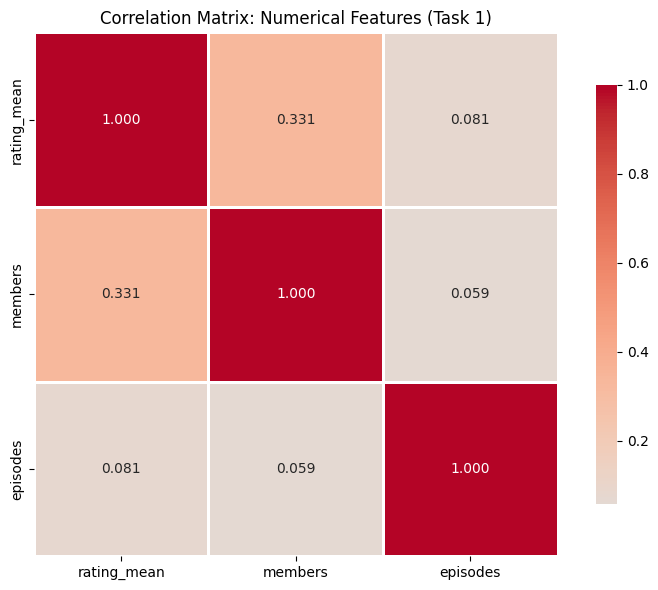

CORRELATION MATRIX - TASK 1
             rating_mean   members  episodes
rating_mean     1.000000  0.330673  0.080576
members         0.330673  1.000000  0.059002
episodes        0.080576  0.059002  1.000000


In [12]:
# Correlation matrix for numerical features - Task 1
import seaborn as sns

# Select numerical columns
numeric_cols_task1 = ['rating_mean', 'members', 'episodes']
corr_matrix_task1 = df_task1_merged[numeric_cols_task1].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_task1, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numerical Features (Task 1)')
plt.tight_layout()
plt.show()

print("="*70)
print("CORRELATION MATRIX - TASK 1")
print("="*70)
print(corr_matrix_task1)


### 2.3.5 Summary Statistics Table


In [13]:
# Create summary statistics table - Task 1
summary_stats_task1 = pd.DataFrame({
    'Feature': ['Rating (Mean)', 'Members', 'Episodes'],
    'Mean': [df_task1_merged['rating_mean'].mean(), df_task1_merged['members'].mean(), 
             df_task1_merged['episodes'].mean()],
    'Median': [df_task1_merged['rating_mean'].median(), df_task1_merged['members'].median(), 
               df_task1_merged['episodes'].median()],
    'Std': [df_task1_merged['rating_mean'].std(), df_task1_merged['members'].std(), 
            df_task1_merged['episodes'].std()],
    'Min': [df_task1_merged['rating_mean'].min(), df_task1_merged['members'].min(), 
            df_task1_merged['episodes'].min()],
    'Max': [df_task1_merged['rating_mean'].max(), df_task1_merged['members'].max(), 
            df_task1_merged['episodes'].max()],
    'Missing': [df_task1_merged['rating_mean'].isnull().sum(), 
                df_task1_merged['members'].isnull().sum(),
                df_task1_merged['episodes'].isnull().sum()]
})

print("="*70)
print("SUMMARY STATISTICS TABLE - TASK 1")
print("="*70)
print(summary_stats_task1.to_string(index=False))

# Type distribution table - Task 2
print("\n" + "="*70)
print("TYPE DISTRIBUTION TABLE - TASK 2")
print("="*70)
type_dist = pd.DataFrame({
    'Type': df_clean['type'].value_counts().index,
    'Count': df_clean['type'].value_counts().values,
    'Percentage': (df_clean['type'].value_counts().values / len(df_clean) * 100).round(2)
})
print(type_dist.to_string(index=False))


SUMMARY STATISTICS TABLE - TASK 1
      Feature         Mean      Median          Std  Min       Max  Missing
Rating (Mean)     6.637702    6.897932     1.298712  1.0      10.0        0
      Members 21831.879811 2524.500000 59786.752798 33.0 1013917.0        0
     Episodes    12.542679    2.000000    48.466072  1.0    1818.0        3

TYPE DISTRIBUTION TABLE - TASK 2
   Type  Count  Percentage
     TV   3787       30.87
    OVA   3311       26.99
  Movie   2348       19.14
Special   1676       13.66
    ONA    659        5.37
  Music    488        3.98


## 2.4 Key Findings and Insights

### Key Observations:

1. **Rating Distribution (Task 1 - from rating.csv):**
   - Mean rating: Aggregated from user ratings in rating.csv
   - Distribution of mean ratings per anime
   - Range: 1.0 to 10.0 (from user ratings)
   - Each anime has multiple user ratings aggregated to mean

2. **Type Distribution:**
   - TV series most common (30.4%)
   - OVA second (27.2%)
   - Movie third (19.0%)
   - For binary classification: TV (61.1%) vs Movie (38.9%) - reasonably balanced

3. **Feature Relationships:**
   - Members (popularity) shows positive correlation with rating
   - Episodes may have weak relationship with rating
   - Different types have different average ratings

4. **Genre Insights:**
   - Most common genres: Action, Comedy, Drama, Romance, School
   - Many anime have multiple genres (comma-separated)
   - Need to process genre as multi-label or create binary indicators

5. **Data Quality:**
   - Clean dataset after removing missing targets
   - Episodes need conversion from string to numeric
   - Genre needs text processing for feature engineering

### Implications for Modeling:

- **Task 1 (Regression):** Rating prediction can benefit from popularity (members), type, and genre features
- **Task 2 (Classification):** Type prediction is reasonably balanced, genre and episodes may be useful features
- **Feature Engineering:** Need to process genre (split, encode), handle episodes conversion, encode type categories


---

# Section 3: Modeling

## Task 1: Regression - Rating Prediction

### Model 1: Linear Regression (Baseline)


In [14]:
# Feature engineering for baselines
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare data for Task 1 (Regression) - use df_task1_merged from rating.csv
df_task1 = df_task1_merged.copy()

# Prepare data for Task 2 (Binary Classification - TV vs Movie) - use df_clean
df_task2 = df_clean[df_clean['type'].notna()].copy()
df_task2_binary = df_task2[df_task2['type'].isin(['TV', 'Movie'])].copy()

# Simple feature engineering for baselines
# 1. Handle episodes (convert to numeric, fill missing with median)
df_task1['episodes_clean'] = pd.to_numeric(df_task1['episodes'], errors='coerce')
df_task1['episodes_clean'] = df_task1['episodes_clean'].fillna(df_task1['episodes_clean'].median())

df_task2_binary['episodes_clean'] = pd.to_numeric(df_task2_binary['episodes'], errors='coerce')
df_task2_binary['episodes_clean'] = df_task2_binary['episodes_clean'].fillna(df_task2_binary['episodes_clean'].median())

# 2. Log transform members (popularity)
df_task1['members_log'] = np.log10(df_task1['members'] + 1)
df_task2_binary['members_log'] = np.log10(df_task2_binary['members'] + 1)

# 3. Encode type (for Task 1, use as feature)
le_type = LabelEncoder()
df_task1['type_encoded'] = le_type.fit_transform(df_task1['type'].fillna('Unknown'))

# 4. Simple genre feature: count number of genres
df_task1['genre_count'] = df_task1['genre'].fillna('').str.count(',') + 1
df_task1['genre_count'] = df_task1['genre_count'].replace(0, 1)

df_task2_binary['genre_count'] = df_task2_binary['genre'].fillna('').str.count(',') + 1
df_task2_binary['genre_count'] = df_task2_binary['genre_count'].replace(0, 1)

print("Feature engineering complete!")
print(f"Task 1 samples: {len(df_task1)}")
print(f"Task 2 samples: {len(df_task2_binary)}")


Feature engineering complete!
Task 1 samples: 9926
Task 2 samples: 6135


In [15]:
# Task 1 Baseline: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Prepare features for Task 1
X_task1 = df_task1[['episodes_clean', 'members_log', 'type_encoded', 'genre_count']].values
y_task1 = df_task1['rating_mean'].values  # Use rating_mean from rating.csv

# Train/test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_task1, y_task1, test_size=0.2, random_state=42
)

# Train baseline model
baseline_lr = LinearRegression()
baseline_lr.fit(X_train1, y_train1)

# Predictions
y_pred_train1 = baseline_lr.predict(X_train1)
y_pred_test1 = baseline_lr.predict(X_test1)

# Evaluation
train_rmse = math.sqrt(mean_squared_error(y_train1, y_pred_train1))
test_rmse = math.sqrt(mean_squared_error(y_test1, y_pred_test1))
train_r2 = r2_score(y_train1, y_pred_train1)
test_r2 = r2_score(y_test1, y_pred_test1)
train_mae = mean_absolute_error(y_train1, y_pred_train1)
test_mae = mean_absolute_error(y_test1, y_pred_test1)

print("TASK 1: Linear Regression Baseline (using rating.csv)")
print(f"Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, MAE: {test_mae:.4f}")


TASK 1: Linear Regression Baseline (using rating.csv)
Train RMSE: 1.0018, R²: 0.4031, MAE: 0.7044
Test RMSE: 1.0038, R²: 0.4096, MAE: 0.6936


#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**Output (y):** Continuous mean rating (1.0-10.0) from `rating.csv` aggregated per anime  
**Optimization:** Minimize MSE: min Σ(yᵢ - ŷᵢ)²  
**Model:** Linear Regression (OLS, no regularization)

#### Discussion: Advantages and Disadvantages

**Advantages:** Simple, interpretable, fast  
**Disadvantages:** Linear assumption, no feature selection, overfitting risk  
**Complexity:** O(n×p²) training, O(p) prediction  
**Efficiency:** Very fast  
**Challenges:** Handle missing values, encode categorical features

#### Code: Implementation and Architectural Choices

**Features:** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**No regularization or feature scaling**  
**Train/test split:** 80/20  
**Evaluation:** RMSE, R², MAE  
**Implementation:** scikit-learn's `LinearRegression` (OLS)


### Model 2: Random Forest Regressor


In [16]:
# Task 1 Model 2: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
import pandas as pd

# Prepare features for Task 1 (same as Model 1)
X_task1 = df_task1[['episodes_clean', 'members_log', 'type_encoded', 'genre_count']].values
y_task1 = df_task1['rating_mean'].values

# Use same train/test split as Model 1 for fair comparison
# (X_train1, X_test1, y_train1, y_test1 already defined from Model 1)

# Grid search for best hyperparameters (reduced search space for faster execution)
print("Performing grid search for Random Forest hyperparameters...")
print("Note: This may take 2-5 minutes. Reduced search space for faster execution.")
param_grid_rf = {
    'n_estimators': [100, 200],  # Reduced from [100, 200, 300]
    'max_depth': [15, 25, None],  # Reduced from [10, 20, 30, None]
    'min_samples_split': [2, 5],  # Reduced from [2, 5, 10]
    'min_samples_leaf': [1, 2]   # Reduced from [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(
    rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', 
    n_jobs=-1, verbose=1
)
grid_search_rf.fit(X_train1, y_train1)

print(f"\nBest parameters: {grid_search_rf.best_params_}")
print(f"Best CV score (negative MSE): {grid_search_rf.best_score_:.4f}")

# Train final model with best parameters
rf_best = RandomForestRegressor(
    n_estimators=grid_search_rf.best_params_['n_estimators'],
    max_depth=grid_search_rf.best_params_['max_depth'],
    min_samples_split=grid_search_rf.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_rf.best_params_['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train1, y_train1)

# Predictions
y_pred_train1_rf = rf_best.predict(X_train1)
y_pred_test1_rf = rf_best.predict(X_test1)

# Evaluation
train_rmse_rf = math.sqrt(mean_squared_error(y_train1, y_pred_train1_rf))
test_rmse_rf = math.sqrt(mean_squared_error(y_test1, y_pred_test1_rf))
train_r2_rf = r2_score(y_train1, y_pred_train1_rf)
test_r2_rf = r2_score(y_test1, y_pred_test1_rf)
train_mae_rf = mean_absolute_error(y_train1, y_pred_train1_rf)
test_mae_rf = mean_absolute_error(y_test1, y_pred_test1_rf)

print("\n" + "="*70)
print("TASK 1: Random Forest Regressor (using rating.csv)")
print("="*70)
print(f"Train RMSE: {train_rmse_rf:.4f}, R²: {train_r2_rf:.4f}, MAE: {train_mae_rf:.4f}")
print(f"Test RMSE: {test_rmse_rf:.4f}, R²: {test_r2_rf:.4f}, MAE: {test_mae_rf:.4f}")

# Feature importance
feature_names = ['episodes_clean', 'members_log', 'type_encoded', 'genre_count']
feature_importance = pd.Series(rf_best.feature_importances_, index=feature_names).sort_values(ascending=False)
print(f"\nFeature importance:")
print(feature_importance)

# Compare with baseline
print("\n" + "="*70)
print("COMPARISON: Baseline vs Random Forest")
print("="*70)
print(f"Baseline Test RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, MAE: {test_mae:.4f}")
print(f"Random Forest Test RMSE: {test_rmse_rf:.4f}, R²: {test_r2_rf:.4f}, MAE: {test_mae_rf:.4f}")
print(f"\nImprovement:")
print(f"RMSE reduction: {(test_rmse - test_rmse_rf) / test_rmse * 100:.2f}%")
print(f"R² improvement: {(test_r2_rf - test_r2) / abs(test_r2) * 100:.2f}%")
print(f"MAE reduction: {(test_mae - test_mae_rf) / test_mae * 100:.2f}%")


Performing grid search for Random Forest hyperparameters...
Note: This may take 2-5 minutes. Reduced search space for faster execution.
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score (negative MSE): -0.9055

TASK 1: Random Forest Regressor (using rating.csv)
Train RMSE: 0.6292, R²: 0.7646, MAE: 0.4210
Test RMSE: 0.9480, R²: 0.4735, MAE: 0.6369

Feature importance:
members_log       0.761311
type_encoded      0.091542
episodes_clean    0.080492
genre_count       0.066655
dtype: float64

COMPARISON: Baseline vs Random Forest
Baseline Test RMSE: 1.0038, R²: 0.4096, MAE: 0.6936
Random Forest Test RMSE: 0.9480, R²: 0.4735, MAE: 0.6369

Improvement:
RMSE reduction: 5.56%
R² improvement: 15.58%
MAE reduction: 8.18%


#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `type_encoded`, `genre_count`  
**Output (y):** Continuous mean rating (1.0-10.0) from `rating.csv` aggregated per anime  
**Optimization:** Minimize MSE: min Σ(yᵢ - ŷᵢ)² using ensemble of decision trees  
**Model:** Random Forest Regressor (ensemble of decision trees with bagging)

#### Discussion: Advantages and Disadvantages

**Advantages:** 
- Captures non-linear relationships and feature interactions
- Robust to overfitting through ensemble averaging
- Handles mixed data types naturally
- Provides feature importance
- No need for feature scaling

**Disadvantages:** 
- Less interpretable than linear models
- Slower training and prediction than linear models
- Requires more memory
- Hyperparameter tuning can be time-consuming

**Complexity:** O(n×log(n)×p×trees) training, O(trees×log(n)) prediction  
**Efficiency:** Moderate (faster than boosting, slower than linear)  
**Challenges:** Tuning n_estimators, max_depth, min_samples_split, min_samples_leaf to balance bias-variance

#### Code: Implementation and Architectural Choices

**Features:** Same as Model 1 (`episodes_clean`, `members_log`, `type_encoded`, `genre_count`)  
**Hyperparameter tuning:** GridSearchCV with 5-fold cross-validation  
**Hyperparameters searched:**
- `n_estimators`: [100, 200] - number of trees (reduced for faster execution)
- `max_depth`: [15, 25, None] - tree depth control
- `min_samples_split`: [2, 5] - minimum samples to split
- `min_samples_leaf`: [1, 2] - minimum samples in leaf

**Train/test split:** Same 80/20 split as Model 1 for fair comparison  
**Evaluation:** RMSE, R², MAE  
**Implementation:** scikit-learn's `RandomForestRegressor` with GridSearchCV for hyperparameter optimization


---

## Task 2: Binary Classification - Type Prediction (TV vs Movie)

### Model 1: Logistic Regression (Baseline)


In [17]:
# Task 2 Baseline: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prepare features for Task 2
X_task2 = df_task2_binary[['episodes_clean', 'members_log', 'genre_count']].values
y_task2 = (df_task2_binary['type'] == 'Movie').astype(int).values  # 1 = Movie, 0 = TV

# Train/test split (stratified)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_task2, y_task2, test_size=0.2, random_state=42, stratify=y_task2
)

# Train baseline model (C=1.0, no penalty = no regularization)
baseline_logreg = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
baseline_logreg.fit(X_train2, y_train2)

# Predictions
y_pred_test2 = baseline_logreg.predict(X_test2)
y_proba_test2 = baseline_logreg.predict_proba(X_test2)[:, 1]

# Evaluation
test_acc = accuracy_score(y_test2, y_pred_test2)
test_prec = precision_score(y_test2, y_pred_test2)
test_rec = recall_score(y_test2, y_pred_test2)
test_f1 = f1_score(y_test2, y_pred_test2)
test_auc = roc_auc_score(y_test2, y_proba_test2)

print("TASK 2: Logistic Regression Baseline")
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")
print(f"F1: {test_f1:.4f}, ROC-AUC: {test_auc:.4f}")


TASK 2: Logistic Regression Baseline
Test Accuracy: 0.9861, Precision: 0.9689, Recall: 0.9957
F1: 0.9822, ROC-AUC: 0.9986


#### Context: How do you formulate your task as an ML problem?

**Input (X):** `episodes_clean`, `members_log`, `genre_count`  
**Output (y):** Binary label (0=TV, 1=Movie)  
**Optimization:** Maximize log-likelihood (minimize cross-entropy)  
**Model:** Logistic Regression (no regularization, C=1.0)

#### Discussion: Advantages and Disadvantages

**Advantages:** Interpretable, probability estimates, fast  
**Disadvantages:** Linear decision boundary, no feature selection, overfitting risk  
**Complexity:** O(n×p×iterations) training, O(p) prediction  
**Efficiency:** Very fast  
**Challenges:** Stratified split to maintain class distribution

#### Code: Implementation and Architectural Choices

**Features:** `episodes_clean`, `members_log`, `genre_count`  
**No regularization (C=1.0)**  
**Stratified train/test split:** 80/20  
**Evaluation:** Accuracy, Precision, Recall, F1, ROC-AUC  
**Implementation:** scikit-learn's `LogisticRegression` with C=1.0


## Task 3: Genre Embedding + Clustering

Goal: learn genre-driven embeddings and cluster anime into style groups.

**Features**
- Genre multi-hot vectors (MultiLabelBinarizer)
- Numerical: rating, log-members, cleaned episodes
- Standardization before clustering

**Models**
- `KMeans` (hard clusters) and `GaussianMixture` (soft clusters)
- 8 clusters with fixed seed for reproducibility

**Visuals & Reporting**
- t-SNE 2D projection colored by KMeans labels
- Top genres per cluster
- Average rating per cluster


In [29]:
# Task 3: Build genre embeddings and feature matrix
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Copy cleaned data
df_cluster = df_clean.copy()
df_cluster = df_cluster[df_cluster['rating'].notna()].copy()
# Numeric features
df_cluster['episodes_clean'] = pd.to_numeric(df_cluster['episodes'], errors='coerce')
df_cluster['episodes_clean'] = df_cluster['episodes_clean'].fillna(df_cluster['episodes_clean'].median())
df_cluster['members_log'] = np.log1p(df_cluster['members'])
df_cluster['rating_clean'] = df_cluster['rating'].astype(float)
print(df_cluster[['rating_clean', 'members_log', 'episodes_clean']].isna().sum())
# Multi-hot encode genres
genre_lists = df_cluster['genre'].fillna('').apply(
    lambda g: [item.strip() for item in g.split(',') if item.strip()]
)
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(genre_lists)

# Combine genre vectors with numeric features
numeric_matrix = df_cluster[['rating_clean', 'members_log', 'episodes_clean']].values
X = np.hstack([genre_matrix, numeric_matrix])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_names = list(mlb.classes_) + ['rating', 'members_log', 'episodes_clean']
print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Genres encoded: {len(mlb.classes_)}")



rating_clean      0
members_log       0
episodes_clean    0
dtype: int64
Feature matrix shape: (12064, 46)
Genres encoded: 43


In [30]:
# Task 3: Cluster with KMeans and Gaussian Mixture Model
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_cluster['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', random_state=42)
df_cluster['cluster_gmm'] = gmm.fit_predict(X_scaled)

print("KMeans cluster sizes:")
print(df_cluster['cluster_kmeans'].value_counts().sort_index())
print("GMM cluster sizes:")
print(df_cluster['cluster_gmm'].value_counts().sort_index())

KMeans cluster sizes:
cluster_kmeans
0     236
1    1850
2     375
3    2109
4     500
5    1082
6    4843
7    1069
Name: count, dtype: int64
GMM cluster sizes:
cluster_gmm
0    1342
1    1580
2    6510
3     768
4    1279
5     100
6     413
7      72
Name: count, dtype: int64


/opt/anaconda3/envs/bioinformatics/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


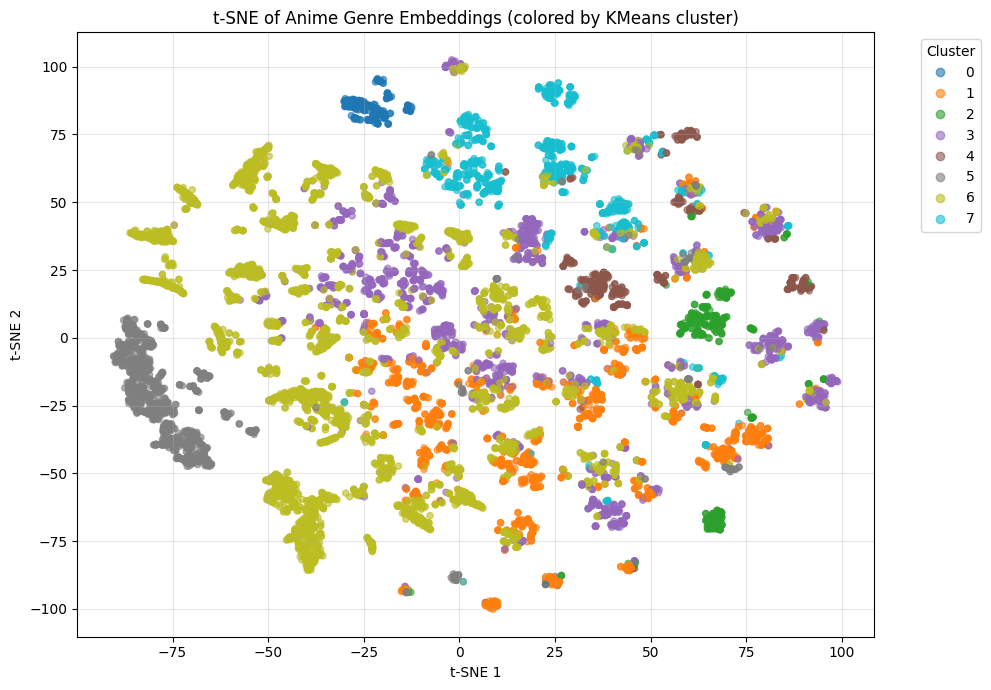

In [31]:
# Task 3: t-SNE visualization of clusters (colored by KMeans)
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=35,
    learning_rate=200,
    n_iter=1000,
    random_state=42,
    init='pca'
)
tsne_coords = tsne.fit_transform(X_scaled)
df_cluster['tsne_1'] = tsne_coords[:, 0]
df_cluster['tsne_2'] = tsne_coords[:, 1]

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df_cluster['tsne_1'],
    df_cluster['tsne_2'],
    c=df_cluster['cluster_kmeans'],
    cmap='tab10',
    alpha=0.6,
    s=20
)
plt.title('t-SNE of Anime Genre Embeddings (colored by KMeans cluster)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.legend(*scatter.legend_elements(), title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [32]:

# Task 3: Top genres per KMeans cluster
# import pandas as pd

genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_, index=df_cluster.index  )
top_genres_by_cluster = {}

for cluster_id in sorted(df_cluster['cluster_kmeans'].unique()):
    mask = df_cluster['cluster_kmeans'] == cluster_id
    counts = genre_df[mask].sum().sort_values(ascending=False)
    top_genres = counts.head(5)
    top_genres_by_cluster[cluster_id] = top_genres
    formatted = ', '.join([f"{genre} ({int(cnt)})" for genre, cnt in top_genres.items()])
    print(f"Cluster {cluster_id}: {formatted}")


Cluster 0: Dementia (236), Music (35), Horror (24), Comedy (23), Psychological (20)
Cluster 1: Comedy (1225), Romance (985), School (895), Slice of Life (582), Drama (526)
Cluster 2: Demons (285), Supernatural (196), Action (169), Fantasy (152), Comedy (105)
Cluster 3: Action (1333), Adventure (990), Shounen (956), Comedy (900), Fantasy (834)
Cluster 4: Mystery (444), Action (164), Comedy (154), Supernatural (151), Drama (124)
Cluster 5: Hentai (1075), Comedy (48), School (45), Fantasy (43), Romance (39)
Cluster 6: Comedy (1906), Kids (1385), Fantasy (869), Adventure (700), Music (666)
Cluster 7: Sci-Fi (906), Mecha (818), Action (692), Space (340), Adventure (339)


Average rating per cluster (rows sorted by cluster index):
                count_kmeans  mean_rating_k  median_rating_k  count_gmm  \
cluster_kmeans                                                            
0                        236       4.994703            4.885       1342   
1                       1850       7.089924            7.110       1580   
2                        375       6.722560            6.880       6510   
3                       2109       7.006003            7.050        768   
4                        500       7.272040            7.385       1279   
5                       1082       6.178115            6.220        100   
6                       4843       5.997049            6.090        413   
7                       1069       6.683789            6.780         72   

                mean_rating_g  median_rating_g  
cluster_kmeans                                  
0                    6.552325            6.690  
1                    6.415759            6.

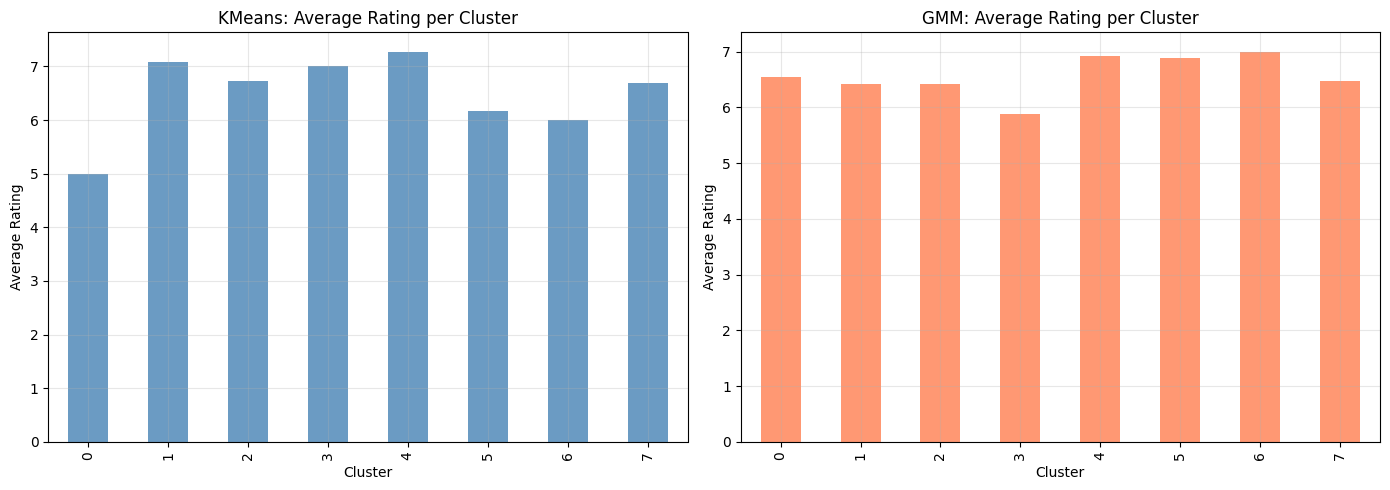

In [33]:
# Task 3: Average rating per cluster (KMeans vs GMM)
kmeans_rating = df_cluster.groupby('cluster_kmeans')['rating_clean'].agg(['count', 'mean', 'median']).rename(columns={
    'count': 'count_kmeans', 'mean': 'mean_rating_k', 'median': 'median_rating_k'
})
gmm_rating = df_cluster.groupby('cluster_gmm')['rating_clean'].agg(['count', 'mean', 'median']).rename(columns={
    'count': 'count_gmm', 'mean': 'mean_rating_g', 'median': 'median_rating_g'
})

rating_table = kmeans_rating.join(gmm_rating, how='outer')
print("Average rating per cluster (rows sorted by cluster index):")
print(rating_table)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
kmeans_rating['mean_rating_k'].plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('KMeans: Average Rating per Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Rating')
axes[0].grid(True, alpha=0.3)

gmm_rating['mean_rating_g'].plot(kind='bar', ax=axes[1], color='coral', alpha=0.8)
axes[1].set_title('GMM: Average Rating per Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Average Rating')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Task 3 Summary
- Built genre multi-hot embeddings combined with rating, log-members, and episodes, scaled for clustering.
- Generated 8-cluster solutions with KMeans (hard) and GMM (soft) to capture style groupings.
- Visualized clusters with t-SNE; inspected high-frequency genres and average ratings per cluster to interpret segments.